# Body Segmentation

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In video production, for example, in weather forecasts, we often need to cut out a human image from camera and place it on top of some other footage. This is typically done using **chroma key** techniques, when a human is filmed in front of a uniform color background, which is then removed. In this lab, we will train a neural network model to cut out the human silhouette.

We will be using [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset) from Kaggle. Download the dataset manually from Kaggle and unzip in into current directory.

In [4]:
dataset_path = 'segmentation_full_body_mads_dataset_1192_img'

import os
import matplotlib.pyplot as plt
import zipfile
import shutil

if not os.path.exists(dataset_path):
    with zipfile.ZipFile('mads_ds_1192.zip') as file:
        file.extractall()
    for dir in os.listdir(os.path.join(dataset_path,dataset_path)):
        shutil.move(os.path.join(dataset_path, dataset_path, dir),
                    os.path.join(dataset_path, dir))
    shutil.rmtree(os.path.join(dataset_path, dataset_path))
    

Let's see how images in the dataset look like:

In [5]:
img_path = os.path.join(dataset_path,'images')
mask_path = os.path.join(dataset_path,'masks')

fnames = os.listdir(img_path)

def load_image(img_name):
    img = plt.imread(os.path.join(img_path,img_name))
    mask = plt.imread(os.path.join(mask_path,img_name))
    return img,mask

(-0.5, 511.5, 383.5, -0.5)

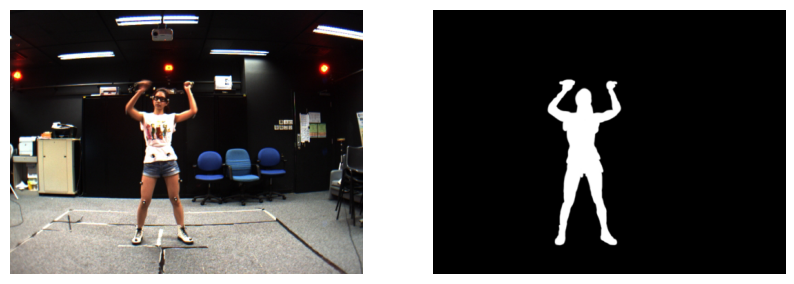

In [6]:
img, mask = load_image(fnames[5])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

In [ ]:
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.io import ImageReadMode
from torch.utils.data import DataLoader, Dataset

from typing import Optional, Callable

class MADSDataset(Dataset):
    def __init__(self, root: str, transforms: Optional[Callable]=None) -> None:
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.imgs_dir = os.path.join(root,'images')
        self.masks_dir = os.path.join(root,'masks')
        self.img_names = [img_name[:-4] for img_name in os.listdir(self.imgs_dir)]

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx) -> tuple(torch.Tensor,torch.Tensor):
        img_path = os.path.join(self.imgs_dir,self.img_names[idx]+'.png')
        img = torchvision.io.read_image(img_path,ImageReadMode.RGB)

        mask_path = os.path.join(self.masks_dir, self.img_names[idx]+'.png')
        mask = torchvision.io.read_image(mask_path, ImageReadMode.RGB)

        target = tv_tensors.Mask(mask)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target